## NEW CFAR 20/09/2025

# CW .wav -> Spectrogram -> 2D CA CFAR -> inline plots + saved PNGs + CSV

In [3]:
# CW .wav -> Spectrogram -> 2D CA CFAR -> inline plots + saved PNGs + CSV

import os
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import wavfile
from scipy.signal import stft
from scipy.ndimage import uniform_filter, label, center_of_mass
import csv

# 1) input folders
DRIVING_DIR = Path(r"field_tests/23_03_25/radar/driving")
WALKING_DIR = Path(r"field_tests/23_03_25/radar/walking")

wav_paths = sorted(DRIVING_DIR.glob("*.wav")) + sorted(WALKING_DIR.glob("*.wav"))

print(f"found {len(wav_paths)} wav files")

# 2) outputs
OUT_DIR = Path("cfar_out")
OUT_DIR.mkdir(parents=True, exist_ok=True)

# show control
SHOW_IN_NOTEBOOK = True      
MAX_FILES_TO_SHOW = 9999        # number of graphs to show 

# 3) spectrogram settings
nperseg = 4096                  # The size of each audio chunk (bigger chunk = better frequency detail)
noverlap = int(0.75 * nperseg)
window = "hann"

# 4) CFAR settings
train_w = (16, 16)    # freq bins, time bins
guard_w = (5, 5)     # freq bins, time bins
pfa = 1e-5


# For InnoSenT CDM324 radar at 24.125 GHz: 44.68 Hz per km/h
DOPPLER_CONSTANT = 44.68  # Hz per (km/h)


# 5) functions
def read_wav_safe(wav_path: Path):
    """Reads a .wav file safely and prepares it for processing."""
    fs, x = wavfile.read(wav_path)
    if x is None or x.size == 0:
        raise ValueError("empty audio")
    # If the audio is stored as integers, convert it to floats between -1.0 and 1.0
    
    if x.dtype.kind in ("i", "u"):
        maxv = np.iinfo(x.dtype).max
        x = x.astype(np.float32) / maxv
    else:
        x = x.astype(np.float32)
        
    # If it's a stereo file, use only the first channel (left channel)
    if x.ndim == 2:
        x = x[:, 0]
    return fs, x

def make_spectrogram(x, fs, nperseg, noverlap, window):
    f, t, Zxx = stft(
        x, fs=fs, window=window,
        nperseg=nperseg, noverlap=noverlap,
        return_onesided=True, boundary=None
    )
    # Convert the complex values to power (magnitude squared)
    S = np.abs(Zxx)**2
    S = np.nan_to_num(S, nan=0.0, posinf=0.0, neginf=0.0)
    return f, t, S

def box_mean(arr, size_f, size_t):
    """Calculates the average value in a moving box (used to estimate noise)."""
    return uniform_filter(arr, size=(size_f, size_t), mode="nearest")

def cfar_2d_ca(S, train_w, guard_w, pfa):
    """The main target detection algorithm (2D Cell-Averaging CFAR)."""
    tf, tt = train_w   # Training cells in Frequency and Time
    gf, gt = guard_w

    # Calculate the total size of the area we will look at (Training + Guard + Cell Under Test)
    tot_f = 2*tf + 2*gf + 1  # Total height of the area
    tot_t = 2*tt + 2*gt + 1  # Total width of the area
    guardcell_f = 2*gf + 1
    guardcell_t = 2*gt + 1

    # Step 1: Calculate the average power in the TOTAL area (Training + Guard + CUT) around every point
    mean_tot = box_mean(S, tot_f, tot_t)
    
     # Step 2: Calculate the average power in just the GUARD area around every point
    mean_gc  = box_mean(S, guardcell_f, guardcell_t)

     # Step 3: Convert averages to sums
    sum_tot = mean_tot * (tot_f * tot_t)
    sum_gc  = mean_gc  * (guardcell_f * guardcell_t)

    # Step 4: The sum of the TRAINING cells is the total sum minus the guard sum
    sum_train = sum_tot - sum_gc - S
    Ntrain = (tot_f * tot_t) - (guardcell_f * guardcell_t) - 1
    Ntrain = max(int(Ntrain), 1)

    # Step 5: The noise estimate is the average power in the training cells
    noise_est = sum_train / Ntrain

    # Step 6: Calculate the threshold multiplier (alpha) based on how picky we want to be (pfa)
    pfa_eff = np.clip(pfa, 1e-12, 1e-2)         # keep Pfa in a sane range
    alpha = Ntrain * (pfa_eff**(-1.0/Ntrain) - 1.0)
    threshold = alpha * noise_est               # still in power, not dB


    # Step 7: Find detections - where the signal power is higher than the local threshold
    det = S > threshold

    # Step 9: We can't run CFAR on the very edges (not enough surrounding cells), so mark them as no detection
    edge_f = tf + gf
    edge_t = tt + gt
    # det[:edge_f, :] = False
    det[:2, :] = False    # mask only ~2*df ≈ 23 Hz near DC
    det[-edge_f:, :] = False  
    det[:, :edge_t] = False
    det[:, -edge_t:] = False
    return det, threshold, noise_est

def show_and_save_plot(png_path, t, f, S, det, title, show_now):
    """Creates a plot of the spectrogram with detections circled, saves it, and optionally shows it."""
    S_db = 10*np.log10(S + 1e-12)
    plt.figure(figsize=(9, 4))
    plt.pcolormesh(t, f, S_db, shading="auto")
    plt.xlabel("time [s]")
    plt.ylabel("frequency [Hz]")
    plt.title(title)
    plt.colorbar(label="power [dB]")
    yy, xx = np.nonzero(det)
    if len(xx) > 0:
        plt.scatter(t[xx], f[yy], s=5, marker="o", facecolors="none", edgecolors="k")
    plt.tight_layout()
    plt.savefig(png_path, dpi=150)
    if show_now:
        plt.show()
    else:
        plt.close()
        
def filter_valid_detections(hits, min_snr_db=3, min_velocity=1, max_velocity=200):
    """Remove obvious false detections"""
    valid_hits = []
    for hit in hits:
        t_s, f_hz, snr_db, v_kmh = hit
        velocity = abs(v_kmh)
        
        if (snr_db >= min_snr_db and 
            min_velocity <= velocity <= max_velocity):
            valid_hits.append(hit)
    
    return valid_hits


# 6) main loop
all_hits = []   
shown = 0   # Counter for how many figures we've shown on screen

# Go through each .wav file one by one
for wav_path in wav_paths:
    try:
        # Read the audio file
        fs, x = read_wav_safe(wav_path)
        x = x - np.mean(x)
    except Exception as e:
        print(f"skip {wav_path.name} due to read error: {e}")
        continue # If there's an error, skip this file and go to the next one

        # Calculate the duration of the audio
    dur = len(x) / fs
    print(f"\nprocessing {wav_path.name}  fs={fs} Hz  dur={dur:.2f} s")

    # Create the spectrogram from the audio
    f_axis, t_axis, S = make_spectrogram(x, fs, nperseg, noverlap, window)

    # Set frequency band based on walking vs driving
    if "walking" in str(wav_path).lower():
        max_freq = 4000  
    else:
        max_freq = 4000  
    
    # Apply frequency band
    band_mask = (f_axis >= 0) & (f_axis <= max_freq)
    f_axis_b = f_axis[band_mask]
    S_b = S[band_mask, :]

    # Run the CFAR detector on the spectrogram
    det, thr, noise = cfar_2d_ca(S_b, train_w=train_w, guard_w=guard_w, pfa=pfa)
    
    
   # Get ALL CFAR detections as individual hits
    individual_hits = []
    yy, xx = np.nonzero(det)
    for y, x in zip(yy, xx):
        f_hz = float(f_axis_b[y])
        t_s = float(t_axis[x])
        p_cut = S_b[y, x]
        p_noise = max(noise[y, x], 1e-20)
        snr_lin = p_cut / p_noise
        snr_db = 10.0 * np.log10(snr_lin)

        velocity_kmh = abs(f_hz) / DOPPLER_CONSTANT  # Use absolute value

        individual_hits.append((t_s, f_hz, snr_db, velocity_kmh))

    # Optional: Filter out obvious false detections
    individual_hits = filter_valid_detections(individual_hits)

    png_path = OUT_DIR / f"{wav_path.stem}_cfar.png"
    show_now = SHOW_IN_NOTEBOOK and (shown < MAX_FILES_TO_SHOW)
    show_and_save_plot(
        png_path, t_axis, f_axis_b, S_b, det,
        f"{wav_path.name} spectrogram with CFAR", show_now
    )


    
    print(f"CFAR found {len(individual_hits)} individual detections.")
    for i, (tt_s, ff_hz, ss_db, v_kmh) in enumerate(individual_hits[:8]):
        print(f" {i+1:2d}) t={tt_s:6.3f}s  f={ff_hz:7.1f}Hz  v={v_kmh:5.1f}km/h  SNR≈{ss_db:5.1f}dB")

    for hit in individual_hits: # Use individual_hits
        tt_s, ff_hz, ss_db, v_kmh = hit
        all_hits.append((wav_path.name, tt_s, ff_hz, ss_db, v_kmh))
 
    show_now = True

# 7) write CSV
csv_path = OUT_DIR / "all_detections.csv"
with open(csv_path, "w", newline="") as fcsv:
    w = csv.writer(fcsv)
    w.writerow(["file", "time_s", "freq_hz", "snr_db", "velocity_kmh"])
    
    for name, t_s, f_hz, snr_db, v_kmh in all_hits:
        w.writerow([name, f"{t_s:.6f}", f"{f_hz:.3f}", f"{snr_db:.2f}", f"{v_kmh:.2f}"])

print(f"\nimages saved in: {OUT_DIR.resolve()}")
print(f"csv saved at:    {csv_path.resolve()}")


found 0 wav files

images saved in: C:\Users\Khumo\Downloads\Honours research\Final MODELS\cfar_out
csv saved at:    C:\Users\Khumo\Downloads\Honours research\Final MODELS\cfar_out\all_detections.csv


# Windows Image Server for grafana

In [1]:
# NEW CELL: Windows Image Server
import http.server
import socketserver
import threading
import os

def start_windows_image_server():
    # Use your exact path
    IMAGE_DIR = r"C:\Users\Khumo\Downloads\Honours research\cfar_out"
    
    if not os.path.exists(IMAGE_DIR):
        print(f" Directory doesn't exist: {IMAGE_DIR}")
        return
    
    os.chdir(IMAGE_DIR)
    
    PORT = 8000
    with socketserver.TCPServer(("", PORT), http.server.SimpleHTTPRequestHandler) as httpd:
        print(f" Image server running at: http://localhost:{PORT}")
        print(f" Serving from: {IMAGE_DIR}")
        print("Available images:")
        for file in os.listdir(IMAGE_DIR):
            if file.endswith('.png'):
                print(f"  - http://localhost:8000/{file}")
        httpd.serve_forever()

# Start server in background
server_thread = threading.Thread(target=start_windows_image_server, daemon=True)
server_thread.start()
print("Server started! Your images are now accessible.")

Server started! Your images are now accessible.
 Image server running at: http://localhost:8000
 Serving from: C:\Users\Khumo\Downloads\Honours research\cfar_out
Available images:
  - http://localhost:8000/10km_cfar.png
  - http://localhost:8000/10km_cfar_velocity.png
  - http://localhost:8000/20km_cfar.png
  - http://localhost:8000/20km_cfar_velocity.png
  - http://localhost:8000/40km_cfar.png
  - http://localhost:8000/40km_cfar_velocity.png
  - http://localhost:8000/ADAU1979_MCP6024_Car_Test_1_Athens_cfar.png
  - http://localhost:8000/ADAU1979_MCP6024_Car_Test_2_Athens_cfar.png
  - http://localhost:8000/adc_data_cfar.png
  - http://localhost:8000/another car_cfar.png
  - http://localhost:8000/car 14_cfar.png
  - http://localhost:8000/car 15_cfar.png
  - http://localhost:8000/car 1_cfar.png
  - http://localhost:8000/car 2_cfar.png
  - http://localhost:8000/car 3_cfar.png
  - http://localhost:8000/car 4_cfar.png
  - http://localhost:8000/car 6_cfar.png
  - http://localhost:8000/car 7_c

127.0.0.1 - - [21/Oct/2025 13:29:13] "GET /driving_away_30k_2_cfar.png HTTP/1.1" 200 -
127.0.0.1 - - [21/Oct/2025 13:29:13] "GET /video.png HTTP/1.1" 304 -


# # Visualization of processing stages including window comparison - Single file

Processing: driving_away_50k.wav


C:\Users\Khumo\AppData\Local\Temp\ipykernel_1548\1197921055.py:28: WavFileWarning: Chunk (non-data) not understood, skipping it.
  fs, x_original = wavfile.read(wav_path)


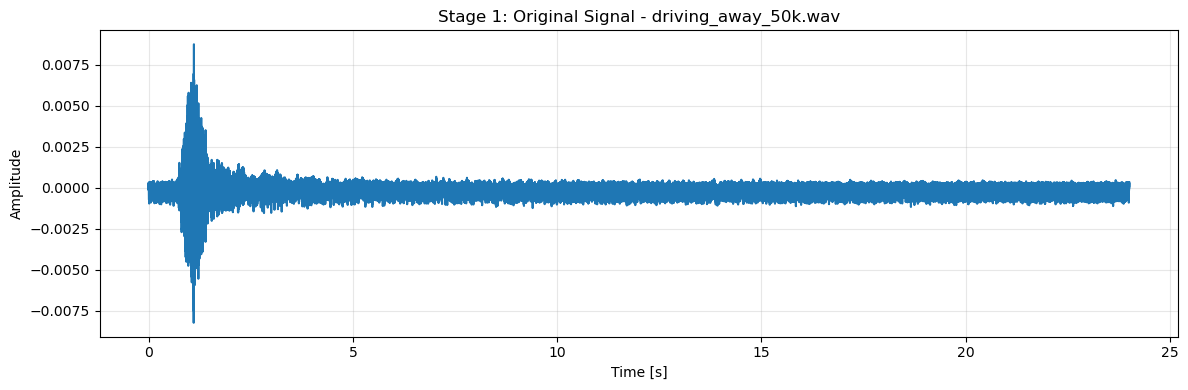

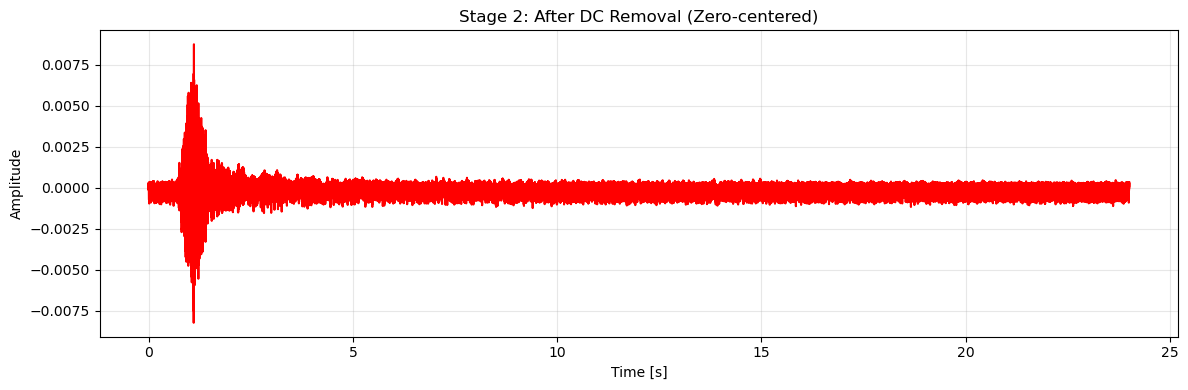

Generating window comparison spectrograms with CFAR detection...
Rectangular window: 562 CFAR detections
Hann window: 658 CFAR detections
Flat-top window: 637 CFAR detections


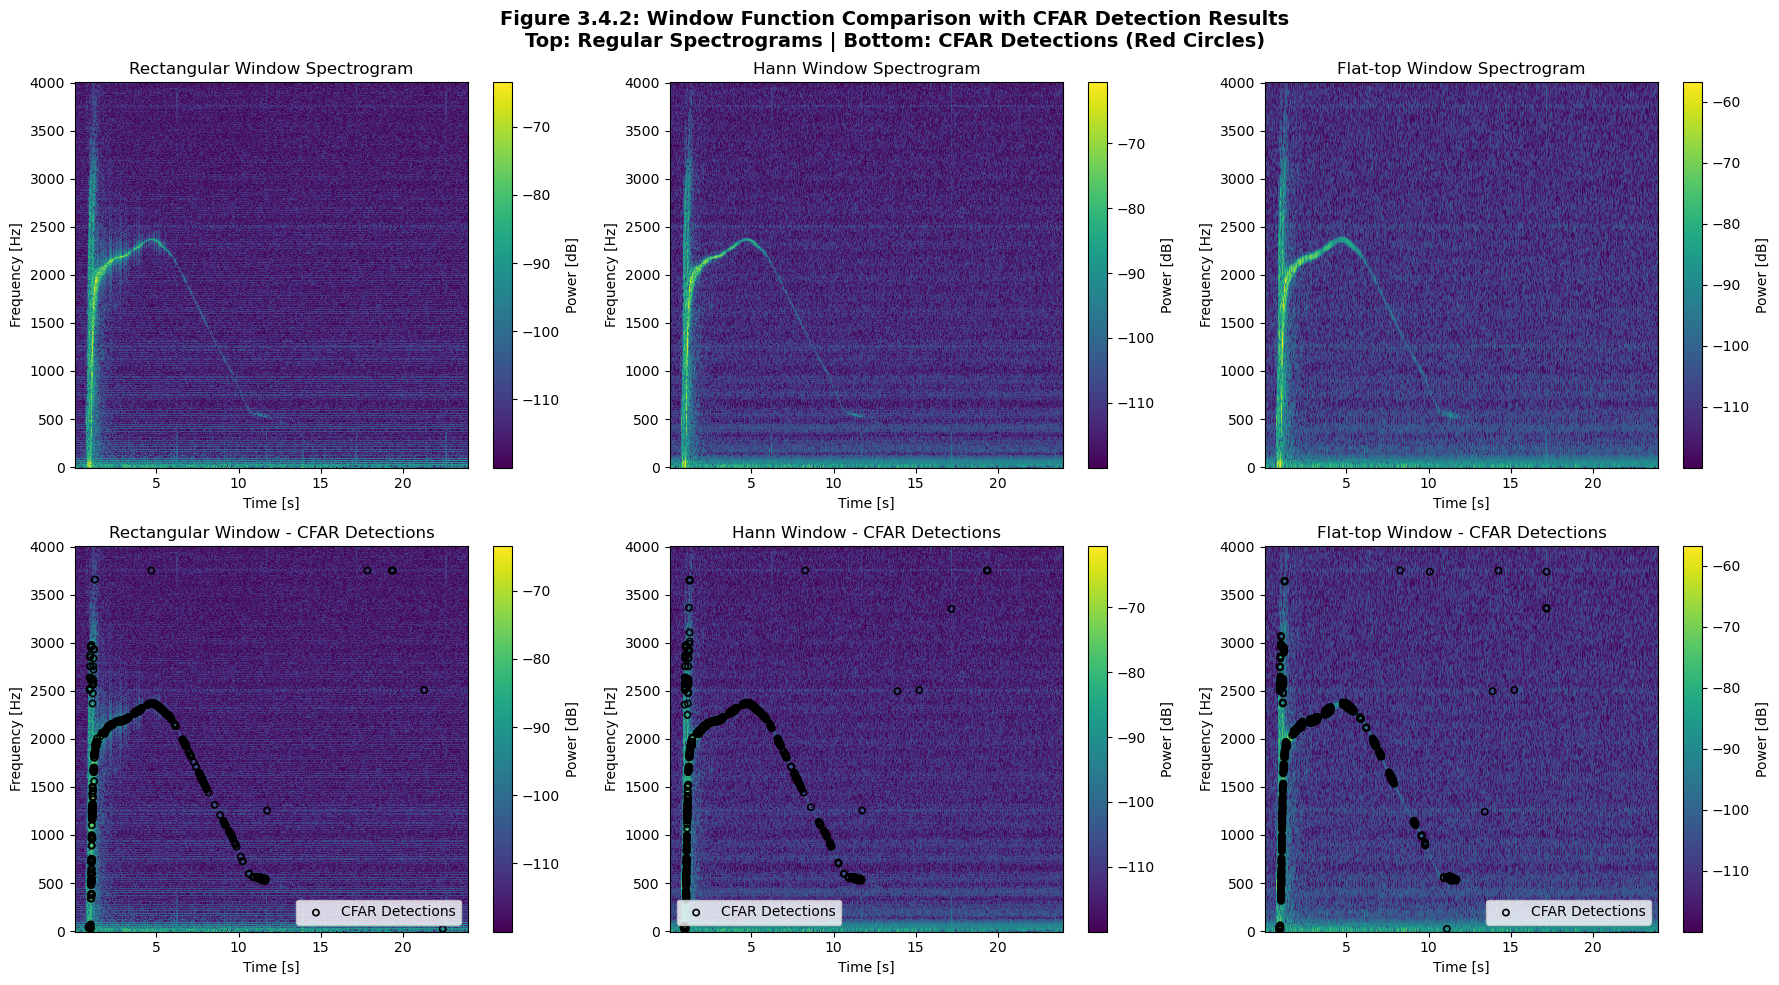

C:\Users\Khumo\AppData\Local\Temp\ipykernel_1548\1197921055.py:185: DeprecationWarning: Importing hann from 'scipy.signal' is deprecated since SciPy 1.1.0 and will raise an error in SciPy 1.13.0. Please use 'scipy.signal.windows.hann' or the convenience function 'scipy.signal.get_window' instead.
  hann_window = hann(len(segment))


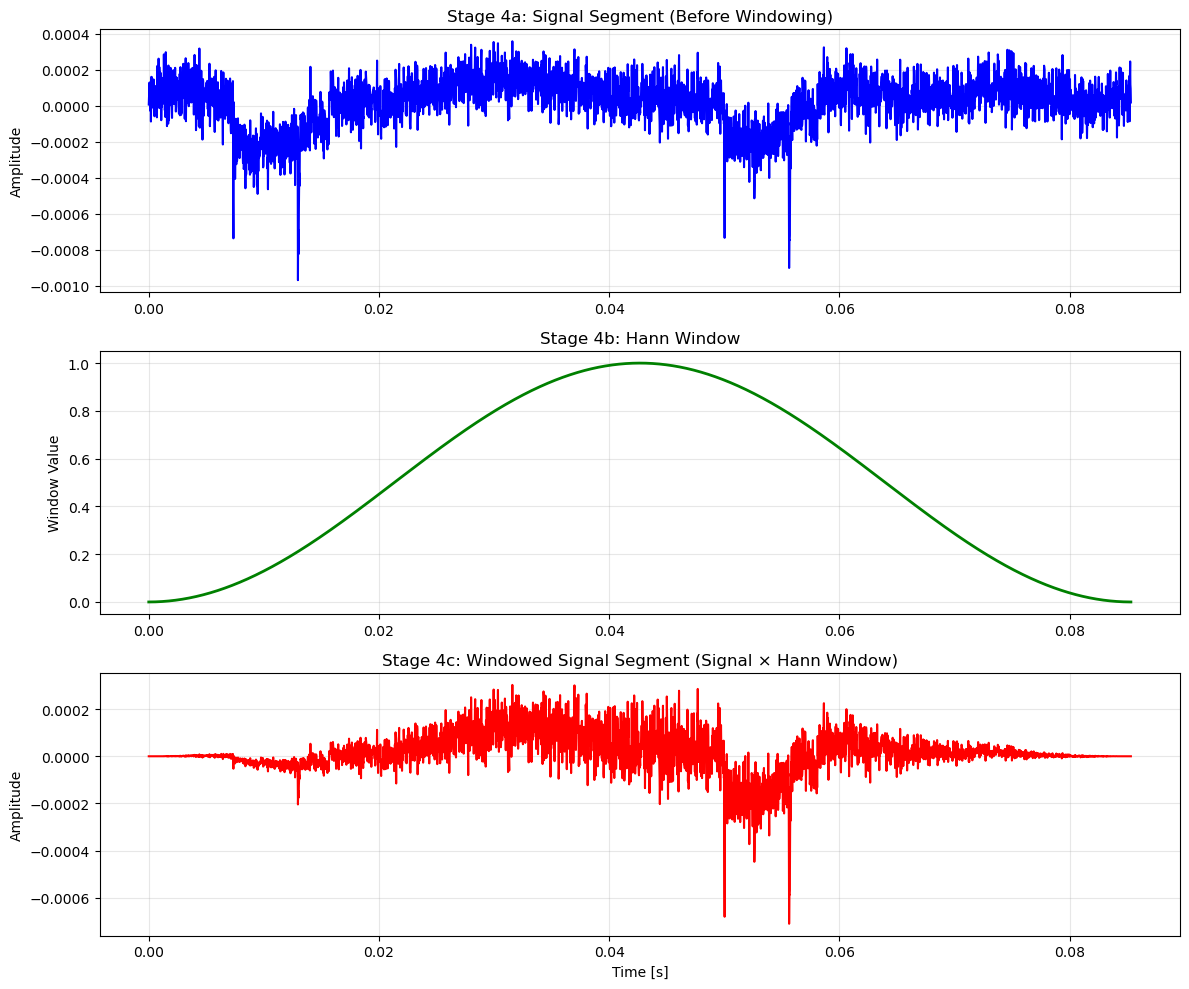

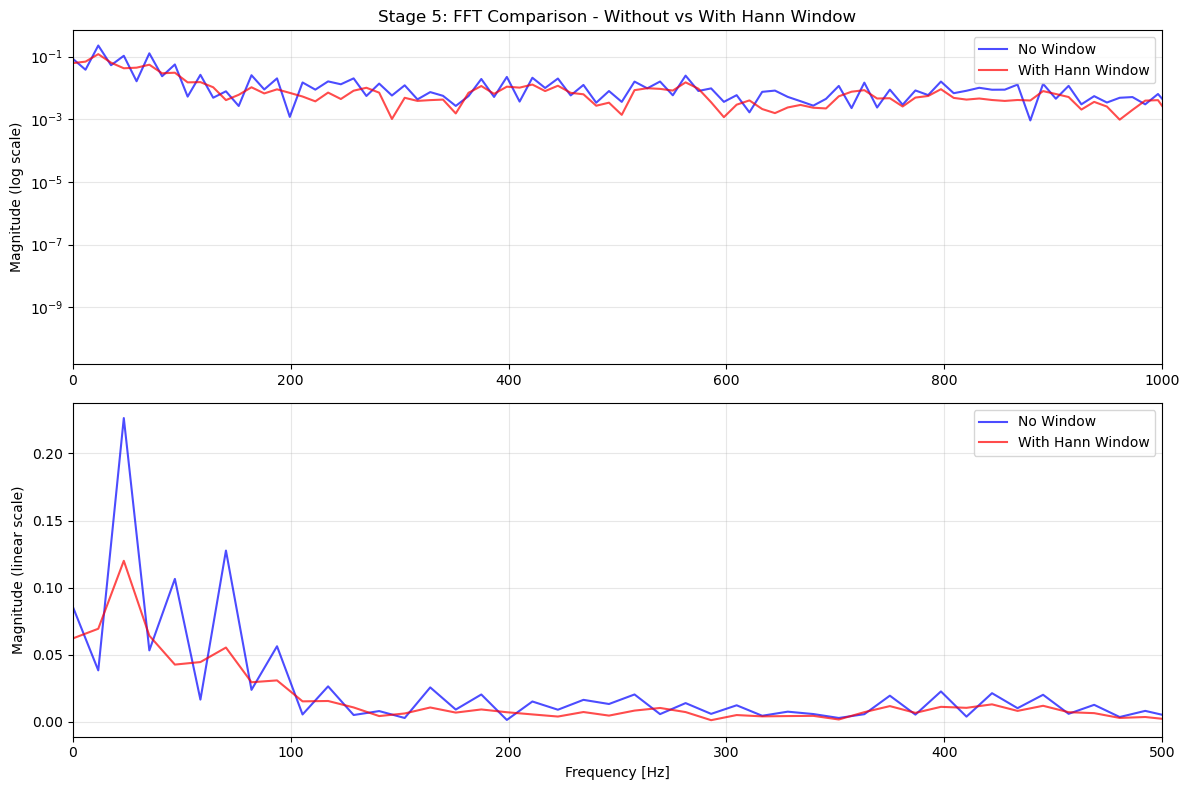

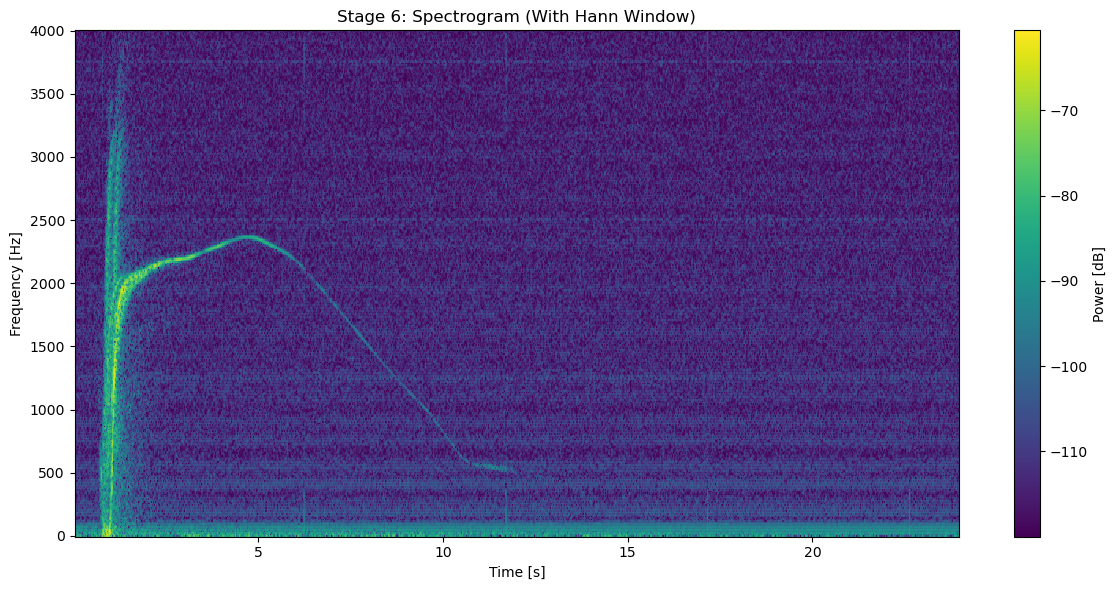

Processing complete for driving_away_50k.wav
Visualizations saved in: C:\Users\Khumo\Downloads\Honours research\processing_stages_single_file
DC component removed: -0.000001


In [35]:
# Visualization of processing stages including window comparison - Single file
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import wavfile
from scipy.signal import stft, hann, get_window
from scipy.ndimage import uniform_filter
from pathlib import Path

def visualize_single_file_with_window_comparison():
    """Generate visualizations for processing stages including window comparison for a single file"""
    
    # Focus on the specific file
    wav_path = Path(r"field_tests/23_03_25/radar/driving/driving_away_50k.wav")
    
    # Create main output directory
    OUTPUT_DIR = Path("processing_stages_single_file")
    OUTPUT_DIR.mkdir(parents=True, exist_ok=True)
    
    # Spectrogram settings
    nperseg = 4096
    noverlap = int(0.75 * nperseg)
    window = "hann"
    
    print(f"Processing: {wav_path.name}")
    
    try:
        # STAGE 1: Read original signal
        fs, x_original = wavfile.read(wav_path)
        
        # Convert to float if needed
        if x_original.dtype.kind in ("i", "u"):
            maxv = np.iinfo(x_original.dtype).max
            x_original = x_original.astype(np.float32) / maxv
        else:
            x_original = x_original.astype(np.float32)
            
        # If stereo, use first channel
        if x_original.ndim == 2:
            x_original = x_original[:, 0]
        
        # Create time axis for plotting
        time_axis = np.arange(len(x_original)) / fs
        
        # Plot original signal
        plt.figure(figsize=(12, 4))
        plt.plot(time_axis, x_original)
        plt.xlabel('Time [s]')
        plt.ylabel('Amplitude')
        plt.title(f'Stage 1: Original Signal - {wav_path.name}')
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.savefig(OUTPUT_DIR / f"01_original_signal.png", dpi=150, bbox_inches='tight')
        plt.show()
        
        # STAGE 2: DC Removal
        dc_component = np.mean(x_original)
        x_dc_removed = x_original - dc_component
        
        plt.figure(figsize=(12, 4))
        plt.plot(time_axis, x_dc_removed, 'r-')
        plt.xlabel('Time [s]')
        plt.ylabel('Amplitude')
        plt.title('Stage 2: After DC Removal (Zero-centered)')
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.savefig(OUTPUT_DIR / f"02_dc_removed.png", dpi=150, bbox_inches='tight')
        plt.show()
        
        # NEW STAGE: 3 Spectrogram Comparison + CFAR Results
        print("Generating window comparison spectrograms with CFAR detection...")
        
        # Define the 3 windows to compare
        windows = {
            'Rectangular': 'boxcar',
            'Hann': 'hann', 
            'Flat-top': 'flattop'
        }
        
        # CFAR function
        def cfar_2d_ca(S, train_w, guard_w, pfa):
            tf, tt = train_w
            gf, gt = guard_w
            tot_f = 2*tf + 2*gf + 1
            tot_t = 2*tt + 2*gt + 1
            guardcell_f = 2*gf + 1
            guardcell_t = 2*gt + 1

            mean_tot = uniform_filter(S, size=(tot_f, tot_t), mode="nearest")
            mean_gc  = uniform_filter(S, size=(guardcell_f, guardcell_t), mode="nearest")

            sum_tot = mean_tot * (tot_f * tot_t)
            sum_gc  = mean_gc  * (guardcell_f * guardcell_t)
            sum_train = sum_tot - sum_gc - S
            Ntrain = (tot_f * tot_t) - (guardcell_f * guardcell_t) - 1
            Ntrain = max(int(Ntrain), 1)

            noise_est = sum_train / Ntrain
            pfa_eff = np.clip(pfa, 1e-12, 1e-2)
            alpha = Ntrain * (pfa_eff**(-1.0/Ntrain) - 1.0)
            threshold = alpha * noise_est

            det = S > threshold
            det[:2, :] = False
            det[-tf-gf:, :] = False  
            det[:, :tt+gt] = False
            det[:, -tt-gt:] = False
            return det, threshold, noise_est
        
        # Create figure for the 3 spectrograms + 3 CFAR results
        fig, axes = plt.subplots(2, 3, figsize=(18, 10))
        
        # CFAR parameters
        train_w = (16, 16)
        guard_w = (5, 5)
        pfa = 1e-5
        
        # Generate spectrograms and CFAR results for each window
        for i, (name, window_type) in enumerate(windows.items()):
            # Top row: Regular spectrograms
            ax_spec = axes[0, i]
            
            # Compute spectrogram with specific window
            f, t, Zxx = stft(
                x_dc_removed, fs=fs, window=window_type,
                nperseg=nperseg, noverlap=noverlap,
                return_onesided=True, boundary=None
            )
            S = np.abs(Zxx)**2
            S = np.nan_to_num(S, nan=0.0, posinf=0.0, neginf=0.0)
            
            # Apply frequency band
            max_freq = 4000
            band_mask = (f >= 0) & (f <= max_freq)
            f_b = f[band_mask]
            S_b = S[band_mask, :]
            
            # Convert to dB
            S_db = 10*np.log10(S_b + 1e-12)
            
            # Plot regular spectrogram
            im_spec = ax_spec.pcolormesh(t, f_b, S_db, shading='auto', cmap='viridis')
            ax_spec.set_xlabel('Time [s]')
            ax_spec.set_ylabel('Frequency [Hz]')
            ax_spec.set_title(f'{name} Window Spectrogram')
            plt.colorbar(im_spec, ax=ax_spec, label='Power [dB]')
            
            # Bottom row: CFAR detection results
            ax_cfar = axes[1, i]
            
            # Run CFAR on this spectrogram
            det, thr, noise = cfar_2d_ca(S_b, train_w=train_w, guard_w=guard_w, pfa=pfa)
            
            # Plot CFAR results - show detections on top of spectrogram
            im_cfar = ax_cfar.pcolormesh(t, f_b, S_db, shading='auto', cmap='viridis')
            
            # Mark detections with black circles
            yy, xx = np.nonzero(det)
            if len(xx) > 0:
                ax_cfar.scatter(t[xx], f_b[yy], s=20, marker="o", 
                              facecolors="none", edgecolors="black", 
                              linewidths=1.2, label='CFAR Detections')
                ax_cfar.legend()
            
            ax_cfar.set_xlabel('Time [s]')
            ax_cfar.set_ylabel('Frequency [Hz]')
            ax_cfar.set_title(f'{name} Window - CFAR Detections')
            plt.colorbar(im_cfar, ax=ax_cfar, label='Power [dB]')
            
            print(f"{name} window: {len(xx)} CFAR detections")
        
        plt.suptitle('Figure 3.4.2: Window Function Comparison with CFAR Detection Results\n'
                    'Top: Regular Spectrograms | Bottom: CFAR Detections (Red Circles)', 
                    fontsize=14, fontweight='bold')
        plt.tight_layout()
        plt.savefig(OUTPUT_DIR / "03_window_comparison_with_CFAR.png", dpi=150, bbox_inches='tight')
        plt.show()
        
        # STAGE 3: Show Hann Window Application
        # Take first segment for demonstration
        segment = x_dc_removed[:nperseg]
        time_segment = np.arange(len(segment)) / fs
        
        # Create Hann window
        hann_window = hann(len(segment))
        segment_windowed = segment * hann_window
        
        # Plot the window application
        fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(12, 10))
        
        # Subplot 1: Original segment
        ax1.plot(time_segment, segment, 'b-', linewidth=1.5)
        ax1.set_ylabel('Amplitude')
        ax1.set_title('Stage 4a: Signal Segment (Before Windowing)')
        ax1.grid(True, alpha=0.3)
        
        # Subplot 2: Hann window
        ax2.plot(time_segment, hann_window, 'g-', linewidth=2)
        ax2.set_ylabel('Window Value')
        ax2.set_title('Stage 4b: Hann Window')
        ax2.grid(True, alpha=0.3)
        
        # Subplot 3: Windowed segment
        ax3.plot(time_segment, segment_windowed, 'r-', linewidth=1.5)
        ax3.set_xlabel('Time [s]')
        ax3.set_ylabel('Amplitude')
        ax3.set_title('Stage 4c: Windowed Signal Segment (Signal × Hann Window)')
        ax3.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.savefig(OUTPUT_DIR / f"04_hann_window_application.png", dpi=150, bbox_inches='tight')
        plt.show()
        
        # STAGE 4: FFT Comparison - Without vs With Hann Window
        fft_nowindow = np.fft.fft(segment)  # Without window
        fft_windowed = np.fft.fft(segment_windowed)  # With Hann window
        freqs = np.fft.fftfreq(len(segment), 1/fs)
        
        # Only plot positive frequencies
        positive_freq_mask = freqs >= 0
        freqs_positive = freqs[positive_freq_mask]
        fft_magnitude_nowindow = np.abs(fft_nowindow[positive_freq_mask])
        fft_magnitude_windowed = np.abs(fft_windowed[positive_freq_mask])
        
        plt.figure(figsize=(12, 8))
        
        plt.subplot(2, 1, 1)
        plt.semilogy(freqs_positive, fft_magnitude_nowindow, 'b-', alpha=0.7, label='No Window', linewidth=1.5)
        plt.semilogy(freqs_positive, fft_magnitude_windowed, 'r-', alpha=0.7, label='With Hann Window', linewidth=1.5)
        plt.ylabel('Magnitude (log scale)')
        plt.title('Stage 5: FFT Comparison - Without vs With Hann Window')
        plt.grid(True, alpha=0.3)
        plt.xlim(0, min(1000, fs/2))
        plt.legend()
        
        plt.subplot(2, 1, 2)
        plt.plot(freqs_positive, fft_magnitude_nowindow, 'b-', alpha=0.7, label='No Window', linewidth=1.5)
        plt.plot(freqs_positive, fft_magnitude_windowed, 'r-', alpha=0.7, label='With Hann Window', linewidth=1.5)
        plt.xlabel('Frequency [Hz]')
        plt.ylabel('Magnitude (linear scale)')
        plt.grid(True, alpha=0.3)
        plt.xlim(0, min(500, fs/2))  # Focus on lower frequencies
        plt.legend()
        
        plt.tight_layout()
        plt.savefig(OUTPUT_DIR / f"05_fft_comparison_window.png", dpi=150, bbox_inches='tight')
        plt.show()
        
        # STAGE 5: Spectrogram (Hann window, the original)
        f, t, Zxx = stft(
            x_dc_removed, fs=fs, window=window,
            nperseg=nperseg, noverlap=noverlap,
            return_onesided=True, boundary=None
        )
        S = np.abs(Zxx)**2
        S = np.nan_to_num(S, nan=0.0, posinf=0.0, neginf=0.0)
        
        # Apply frequency band
        max_freq = 4000
        band_mask = (f >= 0) & (f <= max_freq)
        f_b = f[band_mask]
        S_b = S[band_mask, :]
        
        plt.figure(figsize=(12, 6))
        S_db = 10*np.log10(S_b + 1e-12)
        plt.pcolormesh(t, f_b, S_db, shading='auto', cmap='viridis')
        plt.xlabel('Time [s]')
        plt.ylabel('Frequency [Hz]')
        plt.title('Stage 6: Spectrogram (With Hann Window)')
        plt.colorbar(label='Power [dB]')
        plt.tight_layout()
        plt.savefig(OUTPUT_DIR / f"06_spectrogram.png", dpi=150, bbox_inches='tight')
        plt.show()
        
        print(f"Processing complete for {wav_path.name}")
        print(f"Visualizations saved in: {OUTPUT_DIR.resolve()}")
        print(f"DC component removed: {dc_component:.6f}")
        
    except Exception as e:
        print(f"Error processing {wav_path.name}: {e}")

# Run the visualization for the single file
visualize_single_file_with_window_comparison()

## CW .wav -> Spectrogram -> 2D CA CFAR -> inline plots + saved PNGs + CSV and Feature extraction 

In [2]:
# CW .wav -> Spectrogram -> 2D CA CFAR -> inline plots + saved PNGs + CSV
# DUAL OUTPUT: Individual detections for ML + Grouped targets for Grafana

import os
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import wavfile
from scipy.signal import stft
from scipy.ndimage import uniform_filter, label, center_of_mass
import csv

# 1) input folders
DRIVING_DIR = Path(r"field_tests/23_03_25/radar/driving")
WALKING_DIR = Path(r"field_tests/23_03_25/radar/walking")

wav_paths = sorted(DRIVING_DIR.glob("*.wav")) + sorted(WALKING_DIR.glob("*.wav"))
print(f"found {len(wav_paths)} wav files")

# 2) outputs
OUT_DIR = Path("cfar_out")
OUT_DIR.mkdir(parents=True, exist_ok=True)

# show control
SHOW_IN_NOTEBOOK = True      
MAX_FILES_TO_SHOW = 9999        

# 3) spectrogram settings
nperseg = 4096                  
noverlap = int(0.75 * nperseg)
window = "hann"

# 4) CFAR settings
train_w = (16, 16)    # freq bins, time bins
guard_w = (5, 5)     # freq bins, time bins
pfa = 1e-5

# For InnoSenT CDM324 radar at 24.125 GHz: 44.68 Hz per km/h
DOPPLER_CONSTANT = 44.68  # Hz per (km/h)

# 5) functions
def read_wav_safe(wav_path: Path):
    """Reads a .wav file safely and prepares it for processing."""
    fs, x = wavfile.read(wav_path)
    if x is None or x.size == 0:
        raise ValueError("empty audio")
    
    if x.dtype.kind in ("i", "u"):
        maxv = np.iinfo(x.dtype).max
        x = x.astype(np.float32) / maxv
    else:
        x = x.astype(np.float32)
        
    if x.ndim == 2:
        x = x[:, 0]
    return fs, x

def make_spectrogram(x, fs, nperseg, noverlap, window):
    f, t, Zxx = stft(
        x, fs=fs, window=window,
        nperseg=nperseg, noverlap=noverlap,
        return_onesided=True, boundary=None
    )
    S = np.abs(Zxx)**2
    S = np.nan_to_num(S, nan=0.0, posinf=0.0, neginf=0.0)
    return f, t, S

def box_mean(arr, size_f, size_t):
    """Calculates the average value in a moving box (used to estimate noise)."""
    return uniform_filter(arr, size=(size_f, size_t), mode="nearest")

def cfar_2d_ca(S, train_w, guard_w, pfa):
    """The main target detection algorithm (2D Cell-Averaging CFAR)."""
    tf, tt = train_w
    gf, gt = guard_w

    tot_f = 2*tf + 2*gf + 1
    tot_t = 2*tt + 2*gt + 1
    guardcell_f = 2*gf + 1
    guardcell_t = 2*gt + 1

    mean_tot = box_mean(S, tot_f, tot_t)
    mean_gc  = box_mean(S, guardcell_f, guardcell_t)

    sum_tot = mean_tot * (tot_f * tot_t)
    sum_gc  = mean_gc  * (guardcell_f * guardcell_t)

    sum_train = sum_tot - sum_gc - S
    Ntrain = (tot_f * tot_t) - (guardcell_f * guardcell_t) - 1
    Ntrain = max(int(Ntrain), 1)

    noise_est = sum_train / Ntrain

    pfa_eff = np.clip(pfa, 1e-12, 1e-2)
    alpha = Ntrain * (pfa_eff**(-1.0/Ntrain) - 1.0)
    threshold = alpha * noise_est

    det = S > threshold

    edge_f = tf + gf
    edge_t = tt + gt
    det[:2, :] = False
    det[-edge_f:, :] = False  
    det[:, :edge_t] = False
    det[:, -edge_t:] = False
    return det, threshold, noise_est

def show_and_save_plot(png_path, t, f, S, det, title, show_now):
    """Creates a plot of the spectrogram with detections circled, saves it, and optionally shows it."""
    S_db = 10*np.log10(S + 1e-12)
    plt.figure(figsize=(9, 4))
    plt.pcolormesh(t, f, S_db, shading="auto")
    plt.xlabel("time [s]")
    plt.ylabel("frequency [Hz]")
    plt.title(title)
    plt.colorbar(label="power [dB]")
    yy, xx = np.nonzero(det)
    if len(xx) > 0:
        plt.scatter(t[xx], f[yy], s=5, marker="o", facecolors="none", edgecolors="k")
    plt.tight_layout()
    plt.savefig(png_path, dpi=150)
    if show_now:
        plt.show()
    else:
        plt.close()
        
def filter_valid_detections(hits, min_snr_db=3, min_velocity=1, max_velocity=200):
    """Remove obvious false detections"""
    valid_hits = []
    for hit in hits:
        t_s, f_hz, snr_db, v_kmh = hit
        velocity = abs(v_kmh)
        
        if (snr_db >= min_snr_db and 
            min_velocity <= velocity <= max_velocity):
            valid_hits.append(hit)
    
    return valid_hits

def extract_individual_features(detection, f_axis, t_axis, S, window_f=10, window_t=5):
    """Extract features for each individual detection (for ML training)"""
    t_s, f_hz, snr_db, v_kmh = detection
    
    # Find indices in spectrogram
    t_idx = np.argmin(np.abs(t_axis - t_s))
    f_idx = np.argmin(np.abs(f_axis - f_hz))
    
    # Define local window around detection
    f_start = max(0, f_idx - window_f)
    f_end = min(len(f_axis), f_idx + window_f + 1)
    t_start = max(0, t_idx - window_t)
    t_end = min(len(t_axis), t_idx + window_t + 1)
    
    # Extract local region
    local_region = S[f_start:f_end, t_start:t_end]
    local_freqs = f_axis[f_start:f_end]
    
    if local_region.size == 0:
        return None
    
    features = {}
    
    # Basic detection info
    features['time_of_detection_s'] = t_s
    features['frequency_of_detection_hz'] = f_hz
    features['average_speed_kmh'] = v_kmh
    features['snr_db'] = snr_db
    
    # RCS estimate (from signal power)
    features['rcs_estimate'] = S[f_idx, t_idx]
    
    # Signal intensity (peak power in local region)
    features['signal_intensity'] = np.max(local_region)
    
    # Total signal energy in local region
    features['total_signal_energy'] = np.sum(local_region)
    
    # Speed variance (from frequency spread in local region)
    freq_weights = np.sum(local_region, axis=1)
    if np.sum(freq_weights) > 0:
        weighted_mean_freq = np.average(local_freqs, weights=freq_weights)
        weighted_variance = np.average((local_freqs - weighted_mean_freq)**2, weights=freq_weights)
        features['speed_variance'] = weighted_variance / (DOPPLER_CONSTANT ** 2)
    else:
        features['speed_variance'] = 0.0
    
    # Doppler bandwidth (frequency spread)
    if np.max(local_region) > 0:
        region_db = 10 * np.log10(local_region + 1e-12)
        max_power_db = np.max(region_db)
        mask = region_db >= (max_power_db - 3)
        if np.any(mask):
            bandwidth_freqs = local_freqs[mask.any(axis=1)]
            features['doppler_bandwidth_hz'] = np.ptp(bandwidth_freqs) if len(bandwidth_freqs) > 0 else 0.0
        else:
            features['doppler_bandwidth_hz'] = 0.0
    else:
        features['doppler_bandwidth_hz'] = 0.0
    
    # Frequency spectrum features
    freq_slice = S[:, t_idx]
    if len(freq_slice) > 0:
        freq_slice_normalized = freq_slice / np.max(freq_slice) if np.max(freq_slice) > 0 else freq_slice
        top_freq_indices = np.argsort(freq_slice_normalized)[-5:]
        features['spectrum_peaks_hz'] = f_axis[top_freq_indices].tolist()
        features['spectrum_std_hz'] = np.std(f_axis[freq_slice_normalized > 0.1])
    else:
        features['spectrum_peaks_hz'] = []
        features['spectrum_std_hz'] = 0.0
    
    return features

def extract_target_features(detections, f_axis, t_axis, S, detection_window=0.5):
    """Extract comprehensive features for grouped targets (for Grafana dashboard)"""
    target_features = []
    
    if not detections:
        return target_features
        
    # Sort by time and group detections that are close in time (same target)
    detections.sort(key=lambda x: x[0])
    
    groups = []
    current_group = [detections[0]]
    
    for i in range(1, len(detections)):
        if detections[i][0] - current_group[-1][0] <= detection_window:
            current_group.append(detections[i])
        else:
            if len(current_group) >= 2:  # Only consider groups with multiple detections
                groups.append(current_group)
            current_group = [detections[i]]
    if len(current_group) >= 2:
        groups.append(current_group)
    
    for group_idx, group in enumerate(groups):
        times = np.array([d[0] for d in group])
        freqs = np.array([d[1] for d in group])
        snrs = np.array([d[2] for d in group])
        velocities = np.array([d[3] for d in group])
        
        # Basic statistics
        avg_speed = np.mean(velocities)
        speed_variance = np.var(velocities)
        main_frequency = np.mean(freqs)
        avg_snr = np.mean(snrs)
        detection_time = np.mean(times)
        duration = times.max() - times.min()
        
        # Extract signal region around target
        time_mask = (t_axis >= times.min() - 0.1) & (t_axis <= times.max() + 0.1)
        freq_mask = (f_axis >= freqs.min() - 50) & (f_axis <= freqs.max() + 50)
        
        if np.any(time_mask) and np.any(freq_mask):
            target_region = S[freq_mask, :][:, time_mask]
            
            # RCS estimation (proportional to signal power)
            rcs_estimate = np.max(target_region)
            
            # Total signal energy
            total_energy = np.sum(target_region)
            
            # Signal intensity (peak power)
            signal_intensity = np.max(target_region)
            
            # Doppler bandwidth estimation
            doppler_bandwidth = np.std(freqs) * 2
            
            # Frequency spectrum (main components)
            spectrum_sum = np.sum(target_region, axis=1)
            dominant_freqs = f_axis[freq_mask][np.argsort(spectrum_sum)[-3:]]
            
            target_features.append({
                'target_id': f"{group_idx:03d}",
                'average_speed_kmh': avg_speed,
                'rcs_estimate': rcs_estimate,
                'speed_variance': speed_variance,
                'doppler_bandwidth_hz': doppler_bandwidth,
                'detection_time_s': detection_time,
                'main_frequency_hz': main_frequency,
                'average_snr_db': avg_snr,
                'total_signal_energy': total_energy,
                'signal_intensity': signal_intensity,
                'spectrum_peaks_hz': dominant_freqs.tolist(),
                'detection_count': len(group),
                'duration_s': duration,
                'min_speed_kmh': np.min(velocities),
                'max_speed_kmh': np.max(velocities),
                'speed_range_kmh': np.ptp(velocities)
            })
    
    return target_features

# 6) main loop
all_individual_features = []   # For ML training
all_target_features = []       # For Grafana dashboard
shown = 0

for wav_path in wav_paths:
    try:
        fs, x = read_wav_safe(wav_path)
        x = x - np.mean(x)
    except Exception as e:
        print(f"skip {wav_path.name} due to read error: {e}")
        continue

    dur = len(x) / fs
    print(f"\nprocessing {wav_path.name}  fs={fs} Hz  dur={dur:.2f} s")

    # Create the spectrogram
    f_axis, t_axis, S = make_spectrogram(x, fs, nperseg, noverlap, window)

    # Set frequency band
    if "walking" in str(wav_path).lower():
        max_freq = 4000
        target_type = "walking"
    else:
        max_freq = 4000
        target_type = "driving"
    
    band_mask = (f_axis >= 0) & (f_axis <= max_freq)
    f_axis_b = f_axis[band_mask]
    S_b = S[band_mask, :]

    # Run CFAR
    det, thr, noise = cfar_2d_ca(S_b, train_w=train_w, guard_w=guard_w, pfa=pfa)
    
    # Get individual detections
    individual_hits = []
    yy, xx = np.nonzero(det)
    for y, x in zip(yy, xx):
        f_hz = float(f_axis_b[y])
        t_s = float(t_axis[x])
        p_cut = S_b[y, x]
        p_noise = max(noise[y, x], 1e-20)
        snr_lin = p_cut / p_noise
        snr_db = 10.0 * np.log10(snr_lin)
        velocity_kmh = abs(f_hz) / DOPPLER_CONSTANT
        individual_hits.append((t_s, f_hz, snr_db, velocity_kmh))

    # Filter detections
    individual_hits = filter_valid_detections(individual_hits)

    # Extract features for both outputs
    # Individual detections for ML
    for detection in individual_hits:
        features = extract_individual_features(detection, f_axis_b, t_axis, S_b)
        if features:
            features['filename'] = wav_path.name
            features['target_type'] = target_type
            all_individual_features.append(features)

    # Grouped targets for Grafana
    targets = extract_target_features(individual_hits, f_axis_b, t_axis, S_b)
    for target in targets:
        target['filename'] = wav_path.name
        target['target_type'] = target_type
        all_target_features.append(target)

    # Save plot
    png_path = OUT_DIR / f"{wav_path.stem}_cfar.png"
    show_now = SHOW_IN_NOTEBOOK and (shown < MAX_FILES_TO_SHOW)
    show_and_save_plot(
        png_path, t_axis, f_axis_b, S_b, det,
        f"{wav_path.name} spectrogram with CFAR", show_now
    )
    
    print(f"Found {len(individual_hits)} detections -> {len(targets)} targets")
    shown += 1

# 7) Write both CSV files
# Individual detections for ML training
csv_individual_path = OUT_DIR / "individual_detections_ml.csv"
with open(csv_individual_path, "w", newline="") as fcsv:
    fieldnames = [
        'filename', 'target_type', 'time_of_detection_s', 'frequency_of_detection_hz', 
        'average_speed_kmh', 'snr_db', 'rcs_estimate', 'signal_intensity',
        'total_signal_energy', 'speed_variance', 'doppler_bandwidth_hz',
        'spectrum_peaks_hz', 'spectrum_std_hz'
    ]
    
    w = csv.DictWriter(fcsv, fieldnames=fieldnames)
    w.writeheader()
    
    for detection in all_individual_features:
        detection_csv = detection.copy()
        detection_csv['spectrum_peaks_hz'] = str(detection['spectrum_peaks_hz'])
        w.writerow(detection_csv)

# Grouped targets for Grafana dashboard
csv_targets_path = OUT_DIR / "targets_dashboard.csv"
with open(csv_targets_path, "w", newline="") as fcsv:
    fieldnames = [
        'filename', 'target_type', 'target_id', 'detection_time_s', 'duration_s',
        'average_speed_kmh', 'min_speed_kmh', 'max_speed_kmh', 'speed_range_kmh',
        'speed_variance', 'main_frequency_hz', 'average_snr_db', 'rcs_estimate',
        'signal_intensity', 'total_signal_energy', 'doppler_bandwidth_hz',
        'spectrum_peaks_hz', 'detection_count'
    ]
    
    w = csv.DictWriter(fcsv, fieldnames=fieldnames)
    w.writeheader()
    
    for target in all_target_features:
        target_csv = target.copy()
        target_csv['spectrum_peaks_hz'] = str(target['spectrum_peaks_hz'])
        w.writerow(target_csv)

print(f"\nResults saved in: {OUT_DIR.resolve()}")
print(f"Individual detections (ML training): {csv_individual_path} - {len(all_individual_features)} detections")
print(f"Grouped targets (Grafana): {csv_targets_path} - {len(all_target_features)} targets")

found 0 wav files

Results saved in: C:\Users\Khumo\Downloads\Honours research\Final MODELS\cfar_out
Individual detections (ML training): cfar_out\individual_detections_ml.csv - 0 detections
Grouped targets (Grafana): cfar_out\targets_dashboard.csv - 0 targets
